#**SET UP**

In [ ]:
!pip install -q pyspark==3.3.0 spark-nlp==4.2.4

In [ ]:
import sparknlp

spark = sparknlp.start()
# params =>> gpu=False

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 4.2.4
Apache Spark version: 3.3.0


In [ ]:
! cd ~/.ivy2/cache/com.johnsnowlabs.nlp/spark-nlp_2.12/jars && ls -lt

total 43992
-rw-r--r-- 1 root root 45044627 Nov 28 16:37 spark-nlp_2.12-4.2.4.jar


In [ ]:
from pyspark.sql import SparkSession

# create a new Spark session
spark = SparkSession.builder.appName("Segmentation Classifier").getOrCreate()

#**IMPORT LIBRARIES**

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *
from sparknlp.training import CoNLL
import matplotlib.pyplot as plt
import numpy as np

#**READ DATA**

In [ ]:
# Đọc dữ liệu train, validation và test từ file CSV
train_df = spark.read.csv('train.csv', header=True, inferSchema=True)
validation_df = spark.read.csv('validation.csv', header=True, inferSchema=True)
test_df = spark.read.csv('test.csv', header=True, inferSchema=True)

#**DATA PREPROCESSING**

In [ ]:
# Chuyển đổi cột sentiment thành kiểu số nguyên (int)
train_df = train_df.withColumn("sentiment", col("sentiment").cast("int"))
validation_df = validation_df.withColumn("sentiment", col("sentiment").cast("int"))
test_df = test_df.withColumn("sentiment", col("sentiment").cast("int"))

In [ ]:
train_df

DataFrame[sentence: string, sentiment: int, topic: string]

In [ ]:
train_df.printSchema()

root
 |-- sentence: string (nullable = true)
 |-- sentiment: integer (nullable = true)
 |-- topic: string (nullable = true)



In [ ]:
train_df.toPandas().info(verbose=True)
validation_df.toPandas().info(verbose=True)
test_df.toPandas().info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11426 entries, 0 to 11425
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentence   11426 non-null  object 
 1   sentiment  11403 non-null  float64
 2   topic      11426 non-null  object 
dtypes: float64(1), object(2)
memory usage: 267.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3166 entries, 0 to 3165
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentence   3166 non-null   object 
 1   sentiment  3160 non-null   float64
 2   topic      3166 non-null   object 
dtypes: float64(1), object(2)
memory usage: 74.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentence   1583 non-null   object 
 1   sentiment  1579 non-null   float64
 2   topic   

In [ ]:
train_df = train_df.na.drop()
validation_df = validation_df.na.drop()
test_df = test_df.na.drop()

In [ ]:
# Chỉ lấy hai cột 'sentence' và 'sentiment'
train_df = train_df.select(col("sentence"), col("sentiment"))
validation_df = validation_df.select(col("sentence"), col("sentiment"))
test_df = test_df.select(col("sentence"), col("sentiment"))

In [ ]:
train_df.show()

+--------------------+---------+
|            sentence|sentiment|
+--------------------+---------+
|slide giáo trình ...|        2|
|nhiệt tình giảng ...|        2|
|đi học đầy đủ ful...|        0|
|chưa áp dụng công...|        0|
|thầy giảng bài ha...|        2|
|giảng viên đảm bả...|        2|
|em sẽ nợ môn này ...|        1|
|thời lượng học qu...|        0|
|nội dung môn học ...|        0|
|cần nói rõ hơn bằ...|        0|
|thầy rất tận tình...|        2|
|      dễ bị áp lực .|        0|
|đang dạy thầy wzj...|        1|
|môn học còn dễ cầ...|        0|
|có thể cho sinh v...|        0|
|hài lòng về tất cả .|        2|
|nhiệt tình , vui ...|        2|
|thấy nhiệt tình t...|        2|
|phong cách giảng ...|        2|
|giảng dạy kết hợp...|        2|
+--------------------+---------+
only showing top 20 rows



In [ ]:
train_df.printSchema()

root
 |-- sentence: string (nullable = true)
 |-- sentiment: integer (nullable = true)



In [ ]:
# Khởi tạo các annotator của Spark NLP
document_assembler = DocumentAssembler().setInputCol("sentence") \
                                        .setOutputCol("document")

tokenizer = Tokenizer().setInputCols(["document"]) \
                       .setOutputCol("token")

normalizer = Normalizer().setInputCols(["token"]) \
                         .setOutputCol("normalized")

lemmatizer = LemmatizerModel.pretrained() \
                            .setInputCols(["normalized"]) \
                            .setOutputCol("lemma")

stopwords_cleaner = StopWordsCleaner().setInputCols(["lemma"]) \
                                      .setOutputCol("cleanTokens") \
                                      .setCaseSensitive(False)

finisher = Finisher().setInputCols(["cleanTokens"]) \
                     .setOutputCols(["token_features"]) \
                     .setOutputAsArray(True)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [ ]:
# Khởi tạo Pipeline cho quá trình tiền xử lý dữ liệu
preprocessing_pipeline = Pipeline(
  stages = [
    document_assembler,
    tokenizer,
    normalizer,
    lemmatizer,
    stopwords_cleaner,
    finisher
  ])

In [ ]:
# Áp dụng Pipeline để tiền xử lý dữ liệu train, validation và test
train_df = preprocessing_pipeline.fit(train_df).transform(train_df)
validation_df = preprocessing_pipeline.fit(validation_df).transform(validation_df)
test_df = preprocessing_pipeline.fit(test_df).transform(test_df)

In [ ]:
# Khởi tạo CountVectorizer và IDF cho quá trình feature engineering
count_vectorizer = CountVectorizer(inputCol="token_features", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")

# MODEL BUILDING

In [ ]:
class ModelTrainer:
  def __init__(self, train_df, validation_df, test_df, count_vectorizer, idf):
    self.train_df = train_df
    self.validation_df = validation_df
    self.test_df = test_df
    self.count_vectorizer = count_vectorizer
    self.idf = idf

  def train(self, pipeline):
    model = pipeline.fit(self.train_df)
    validation_predictions = model.transform(self.validation_df)
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="sentiment", metricName="accuracy")
    accuracy = evaluator.evaluate(validation_predictions)
    return model, accuracy

  def train_all(self):
    models = []
    validation_accuracies = []
    test_accuracies = []

    # Khởi tạo các mô hình
    lr = LogisticRegression(featuresCol="features", labelCol="sentiment")
    dt = DecisionTreeClassifier(featuresCol="features", labelCol="sentiment")
    rf = RandomForestClassifier(featuresCol="features", labelCol="sentiment")

    # Tạo pipeline cho quá trình train và predict cho mỗi mô hình
    pipelines = [
      Pipeline(stages=[self.count_vectorizer, self.idf, lr]),
      Pipeline(stages=[self.count_vectorizer, self.idf, dt]),
      Pipeline(stages=[self.count_vectorizer, self.idf, rf])
    ]

    # Train và predict trên từng mô hình và lưu kết quả
    for pipeline in pipelines:
      model, validation_accuracy = self.train(pipeline)
      models.append(model)
      validation_accuracies.append(validation_accuracy)
      
      test_prediction = model.transform(self.test_df)
      evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="sentiment", metricName="accuracy")
      test_accuracy = evaluator.evaluate(test_prediction)
      test_accuracies.append(test_accuracy)

    # Tổng hợp accuracies
    accuracies = validation_accuracies + test_accuracies

    # Vẽ biểu đồ trực quan hóa dữ liệu dự đoán
    labels = ['LR', 'DT', 'RF'] * 2
    colors = ['blue', 'orange', 'green'] * 2
    values = accuracies
    plt.bar(labels, values, color=colors)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim((0, 1))
    plt.title('Accuracy of Different Models on Test Data')
    plt.show()

    return models, accuracies, test_prediction

In [ ]:
# Khởi tạo đối tượng ModelTrainer:
trainer = ModelTrainer(train_df, validation_df, test_df, count_vectorizer, idf)

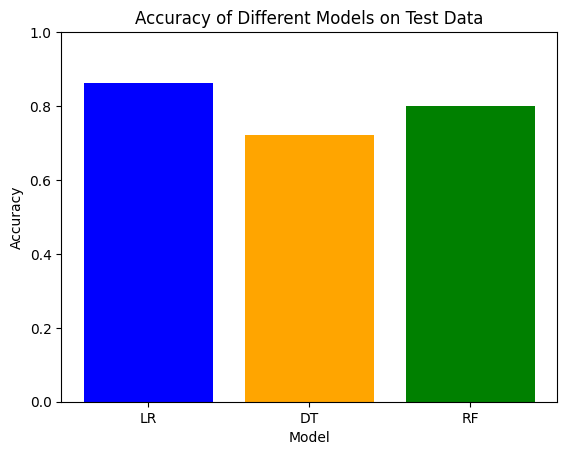

In [ ]:
# Train và đánh giá các mô hình:
models, accuracies, test_predictions = trainer.train_all()